In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import librosa
from tqdm.notebook import tqdm
from IPython.display import Audio
from pandas.api.types import is_numeric_dtype

import sys
sys.path.append('../')
import default_style

TS_DATASET_FOLDER = os.path.join("..", "dataset")
TS_PREPROC_FOLDER = os.path.join(TS_DATASET_FOLDER, "preprocessed_traces")
DF_PREPROC_FILE = os.path.join(TS_PREPROC_FOLDER, "preproc_ts.df")

INTERESTING_TRACES = [ "std_phon_trace", "phonetic_trace","traces_fourier", "syllables_fourier"]

## Save folder for long-run estimators
ESTIMATORS_FOLDER = os.path.join("..", "estimators")

## Import

In [13]:
df = pd.read_csv(DF_PREPROC_FILE)

traces = dict()
for t in INTERESTING_TRACES:
    traces[t] = np.load(os.path.join(TS_PREPROC_FOLDER, f"{t}.npy"), allow_pickle=True)

traces["syll_labels"] = np.repeat(np.arange(7), len(traces["syllables_fourier"])//7)
print(traces["syll_labels"].shape)

(17164,)


## Metrics

In [3]:
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cdist

In [4]:
mat_euclidean = cdist(traces["traces_fourier"],traces["traces_fourier"])

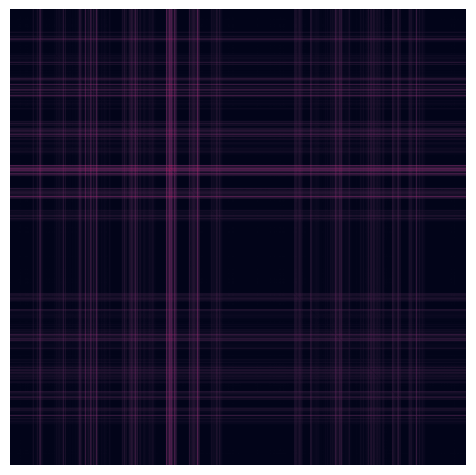

In [5]:
plt.grid("")
plt.axis("off")
plt.imshow(mat_euclidean)

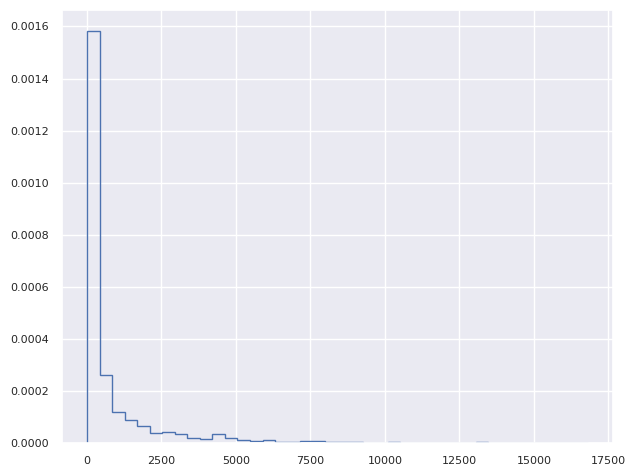

In [6]:
# Distribution of distances
distances_eucl = np.triu(mat_euclidean).reshape(-1)
distances_eucl = distances_eucl[distances_eucl != 0.0]
plt.hist(distances_eucl, histtype="step", bins=40, density=True);

### Manhattan

In [7]:
mat_manhattan = cdist(traces["traces_fourier"],traces["traces_fourier"], metric="cityblock")

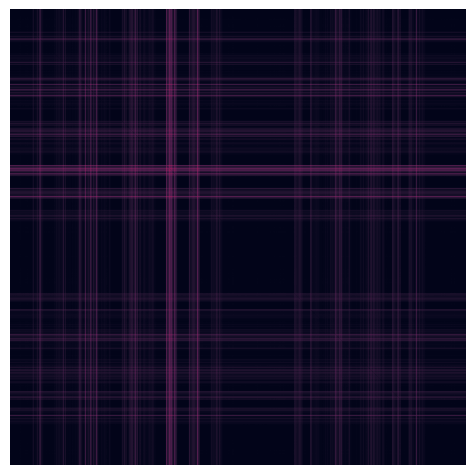

In [8]:
plt.grid("")
plt.axis("off")
plt.imshow(mat_manhattan)

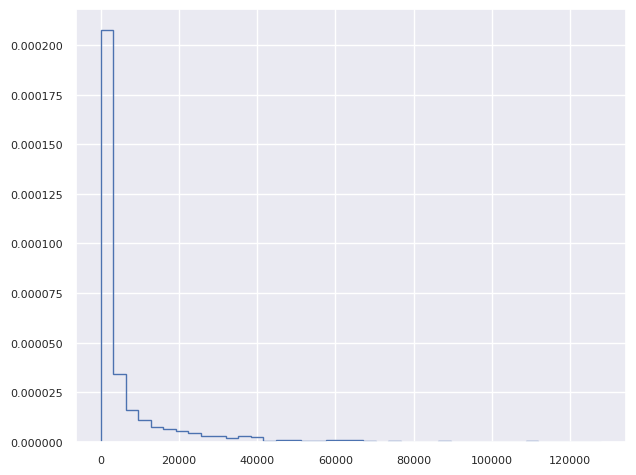

In [9]:
# Distribution of distances
distances_man = np.triu(mat_manhattan).reshape(-1)
distances_man = distances_man[distances_man != 0.0]
plt.hist(distances_man, histtype="step", bins=40, density=True);

### DTW

In [ ]:
from tslearn.metrics import cdist_dtw

mat_dtw = cdist_dtw(traces["std_phon_trace"][:10],traces["std_phon_trace"][:10], itakura_max_slope=2, n_jobs=-1)

In [ ]:
plt.grid("")
plt.axis("off")
plt.imshow(mat_dtw)

## Test: KNN search

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


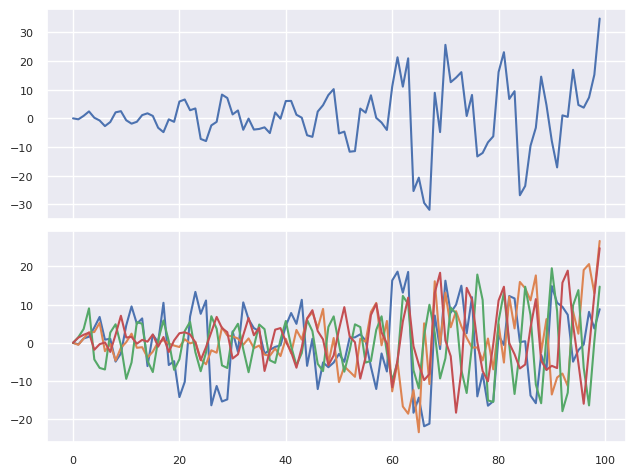

In [10]:
from tslearn.neighbors import KNeighborsTimeSeries
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(traces["traces_fourier"], test_size=0.1)

knn = KNeighborsTimeSeries(n_neighbors=4)
knn.fit(X_train)

# Find nearest neighbours of a query trace
query_trace = 1
nearest = knn.kneighbors([X_test[query_trace]], return_distance=False)[0]

fig, (axquery, axnearest) = plt.subplots(2,1, sharex=True)

# Plot the requested query
axquery.plot(X_test[query_trace])

# Plot the most similar results
for idx in nearest:
    axnearest.plot(X_train[idx])

In [ ]:
X_train.shape

## Kmeans

### Euclidean

1301112.344 --> 1290290.970 --> 1283426.661 --> 1281114.455 --> 1281114.455 --> 
2199
6
1


IndexError: index 1 is out of bounds for axis 0 with size 1

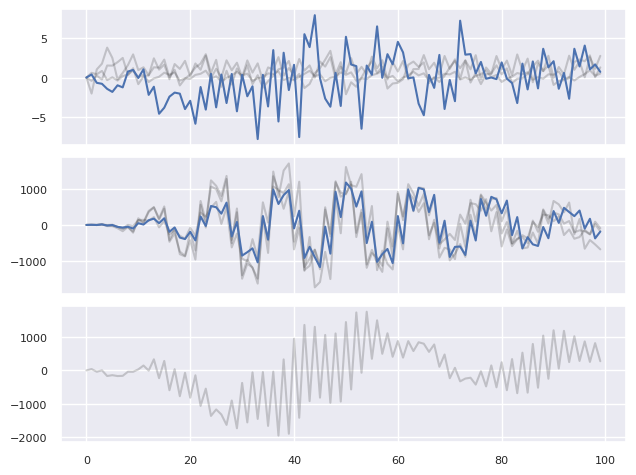

In [16]:
from tslearn.clustering import TimeSeriesKMeans

n_clusters = 3

km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=True)
y_pred = km.fit_predict(X_train)

fig, axes = plt.subplots(n_clusters,1,sharex=True)

for clus in range(n_clusters):
    cluster_elements = X_train[y_pred == clus]
    print(len(cluster_elements))
    for i in range(3):
        axes[clus].plot(cluster_elements[i], alpha=0.2, color="k")
    
    axes[clus].plot(km.cluster_centers_[clus])

### DTW

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2206 out of 2206 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.6s
[Parallel(n_jobs=

624903.079 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 6618 out of 6618 | elapsed:    1.7s finished


516084.937 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 6618 out of 6618 | elapsed:    1.6s finished


510462.549 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 6618 out of 6618 | elapsed:    1.6s finished


509428.263 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 6618 out of 6618 | elapsed:    1.6s finished


509127.598 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 6618 out of 6618 | elapsed:    1.6s finished


509083.059 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 6618 out of 6618 | elapsed:    1.6s finished


509066.976 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 6618 out of 6618 | elapsed:    1.6s finished


509066.976 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 6618 out of 6618 | elapsed:    1.7s finished
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming 

IndexError: index 9 is out of bounds for axis 0 with size 9

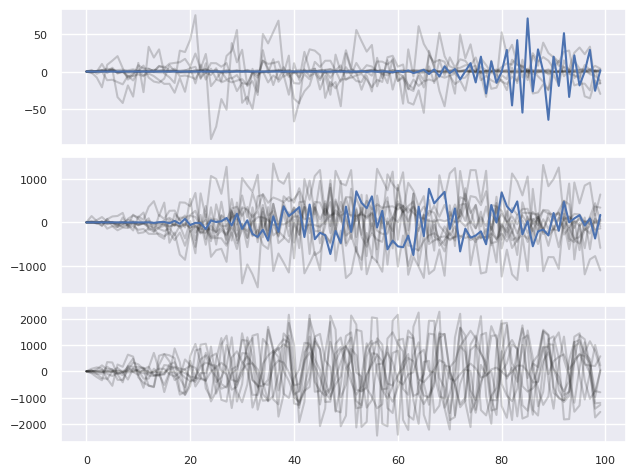

In [17]:
n_clusters = 3

# Fit and save
km = TimeSeriesKMeans(n_clusters=n_clusters,
                      metric="dtw",
                      n_jobs=-1,
                      verbose=True)

y_pred = km.fit_predict(X_train)
# Save the estimator
km.to_pickle(os.path.join(ESTIMATORS_FOLDER, "dtw_kmeans"))

km = TimeSeriesKMeans.from_pickle(os.path.join(ESTIMATORS_FOLDER, "dtw_kmeans"))
y_pred = km.predict(X_train)

fig, axes = plt.subplots(n_clusters,1,sharex=True)

for clus in range(n_clusters):
    cluster_elements = X_train[y_pred == clus]
    for i in range(10):
        axes[clus].plot(cluster_elements[i], alpha=0.2, color="k")
    axes[clus].plot(km.cluster_centers_[clus])

In [24]:
from sklearn.model_selection import train_test_split

X = traces["syllables_fourier"]
y = traces["syll_labels"]

M = 10000
subsamp = np.random.randint(len(X), size=M)

X = X[subsamp]
y = y[subsamp]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

3371135.363 --> 2644260.812 --> 2637402.695 --> 2634796.590 --> 2633784.512 --> 2633238.283 --> 2632937.805 --> 2632737.913 --> 2632618.053 --> 2632567.541 --> 2632526.691 --> 2632496.112 --> 2632471.163 --> 2632419.861 --> 2632392.710 --> 2632348.033 --> 2632311.583 --> 2632291.385 --> 2632271.365 --> 2632243.393 --> 2632214.278 --> 2632143.503 --> 2632097.328 --> 2632047.164 --> 2631996.785 --> 2631944.926 --> 2631891.082 --> 2631851.839 --> 2631818.198 --> 2631761.225 --> 2631683.408 --> 2631594.747 --> 2631476.701 --> 2631351.779 --> 2631276.447 --> 2631226.492 --> 2631173.147 --> 2631118.860 --> 2631075.056 --> 2631043.821 --> 2631018.237 --> 2630996.835 --> 2630978.174 --> 2630970.727 --> 2630959.722 --> 2630958.154 --> 2630957.625 --> 2630957.625 --> 
(array([0, 1, 2]), array([6154, 1535,  311]))
6154
1535
311


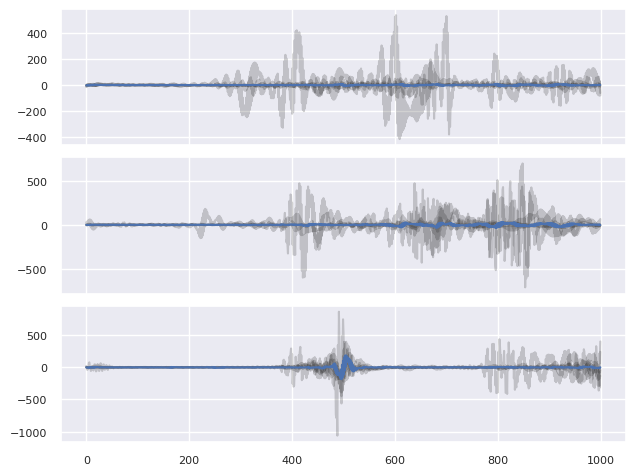

In [30]:
from tslearn.clustering import TimeSeriesKMeans

n_clusters = 

km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=True)
y_pred = km.fit_predict(X_train)
print()
print(np.unique(y_pred, return_counts=True))
print()
fig, axes = plt.subplots(n_clusters,1,sharex=True)

for clus in range(n_clusters):
    cluster_elements = X_train[y_pred == clus]
    for i in range(5):
        axes[clus].plot(cluster_elements[i], alpha=0.2, color="k")
    
    axes[clus].plot(km.cluster_centers_[clus])